In [1]:
%matplotlib inline
import matplotlib_inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

# 生成数据集
构造一个简单的人工训练数据集

In [2]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b # y = wx + b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)

`features`为`1000x2`，`labels`为`1000x1`

In [3]:
print(features[0])
print(labels[0])

tensor([0.4090, 1.3427])
tensor(0.4543)


D:\production\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  This is separate from the ipykernel package so we can avoid doing imports until


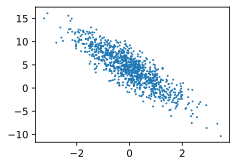

In [4]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')
    
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

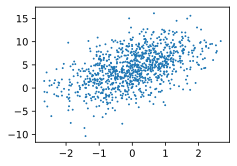

In [7]:
plt.scatter(features[:, 0].numpy(), labels.numpy(), 1)

# 读取数据
随机批量读取数据

In [8]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i : min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        # 对features和labels按行索引，索引序号为j
        yield features.index_select(0, j), labels.index_select(0, j) # yield使函数可迭代

让我们读取第一个小批量数据样本并打印。每个批量的特征形状为(10, 2)，分别对应批量大小和输入个数；标签形状为批量大小。

In [9]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[ 0.3529,  0.3156],
        [ 1.6920, -0.9694],
        [ 2.1082, -0.0173],
        [-2.1224,  0.4630],
        [ 0.5488,  0.2724],
        [-1.0333, -0.2241],
        [-0.0663, -0.3576],
        [-1.9248,  0.7942],
        [ 0.8773,  1.1966],
        [-0.9216, -0.5703]]) tensor([ 3.8318, 10.8802,  8.4797, -1.6201,  4.3665,  2.8746,  5.2801, -2.3320,
         1.8870,  4.3001])


# 初始化模型参数
我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。

In [10]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

之后的模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们要让它们的`requires_grad=True`。

In [14]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

# 定义模型
下面是线性回归的矢量计算表达式的实现。我们使用`mm`函数做矩阵乘法。

In [15]:
def linreg(X, w, b):
    # 矩阵相乘
    return torch.mm(X, w) + b

# 定义损失函数
我们使用上一节描述的平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值`y`变形成预测值`y_hat`的形状。以下函数返回的结果也将和`y_hat`的形状相同。

In [16]:
def squared_loss(y_hat, y):
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

# 定义优化算法
以下的`sgd`函数实现了上一节中介绍的小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [17]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

# 训练模型

In [18]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs): # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。
    # X和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum() # l是有关小批量X和y的损失
        l.backward() # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size) # 使用小批量随机梯度下降迭代模型参数
        
        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.038445
epoch 2, loss 0.000142
epoch 3, loss 0.000052


训练完成后，我们可以比较学到的参数和用来生成训练集的真实参数。它们应该很接近。

In [19]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9998],
        [-3.3993]], requires_grad=True)
4.2 
 tensor([4.1997], requires_grad=True)
